In [1]:
import os 

# move to project root
while True:
    if os.getcwd().split("/")[-1] == "qa_ai":
        break
    else:
        os.chdir("..")

print(os.getcwd())

/home/ra/Codes/qa_ai


In [2]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from src.compute_and_plot_abroca import compute_abroca

In [3]:
# darkgrid, whitegrid, dark, white, ticks
sns.set(style="ticks", context="paper")
plt.style.use("dark_background")

# Some Utils

In [4]:
def compute_accuracy(confusion_matrix):
    """
    Function to compute accuracy from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns accuracy
    """
    return (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)

In [5]:
def compute_true_positive_rate(confusion_matrix):
    """
    Function to compute true positive rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true positive rate
    """
    return confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])

In [6]:
def compute_true_negative_rate(confusion_matrix):
    """
    Function to compute true negative rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true negative rate
    """
    return confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])

In [7]:
def compute_statistical_parity(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute statistical parity from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns statistical parity
    """
    return compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)

In [8]:
def compute_equalized_odds(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute equalized odds from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns equalized odds
    """
    return abs(
        compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)
    ) + abs(
        compute_true_negative_rate(confusion_matrix_group_1) - compute_true_negative_rate(confusion_matrix_group_2)
    )

# Structure
1. Load data
2. Data Visualization
3. Preprocessing
4. Model
5. Evaluation
6. Conclusion

# Loading dataset

In [9]:
data_path = 'data/Homework3_dataset_law.csv'
data_df = pd.read_csv(data_path)

data_df.head()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,fulltime,fam_inc,male,tier,race,pass_bar
0,10.0,10.0,44.0,3.5,1.33,1.88,1.0,5.0,0.0,4.0,White,1.0
1,5.0,4.0,29.0,3.5,-0.11,-0.57,1.0,4.0,0.0,2.0,White,1.0
2,8.0,7.0,37.0,3.4,0.63,0.37,1.0,3.0,1.0,4.0,White,1.0
3,8.0,7.0,43.0,3.3,0.67,0.34,1.0,4.0,0.0,4.0,White,1.0
4,3.0,2.0,41.0,3.3,-0.67,-1.30,1.0,4.0,0.0,5.0,White,1.0


In [10]:
# dictionry of types of data
numerical_features = {
    'decile1b', 
    'decile3', 
    'lsat', 
    'ugpa', 
    'zfygpa', 
    'zgpa', }

binary_features = {
    'fulltime',
    'male',
    'race',}

categorical_features = {
    'fam_inc',
    'tier'}

# Data Visualization

In [11]:
# compare number of white and non-white data
white_df = data_df[data_df['race'] == 'White']
n_white = white_df.shape[0]
print(f'total white data: {n_white}')

non_white_df = data_df[data_df['race']!='White']
n_non_white = non_white_df.shape[0]
print(f'total non-white data: {n_non_white}')

total white data: 17491
total non-white data: 3307


In [12]:
n_passed_white = white_df[white_df['pass_bar'] == 1.0].shape[0] 
n_passed_non_white = non_white_df[non_white_df['pass_bar'] == 1.0].shape[0]

print(f'white pass bar: {n_passed_white}')
print(f'non-white pass bar: {n_passed_non_white}')

white pass bar: 16114
non-white pass bar: 2391


In [13]:
print(f'white pass bar percentage: {n_passed_white * 100/ n_white}')
print(f'non-white pass bar: {n_passed_non_white*100/n_non_white}')

white pass bar percentage: 92.12737979532331
non-white pass bar: 72.30117931660115


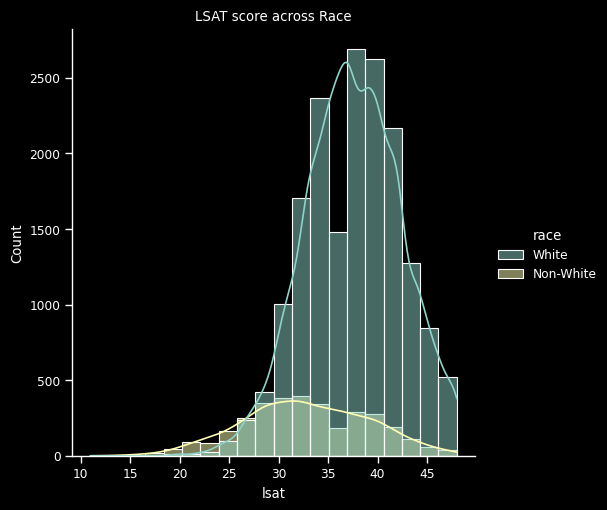

In [14]:
# plot distribution of lsat scores across races
var = 'lsat'
sns.displot(data=data_df, x=var, hue='race', kde=True, bins=20)
plt.title(f'{var.upper()} score across Race')
plt.show()

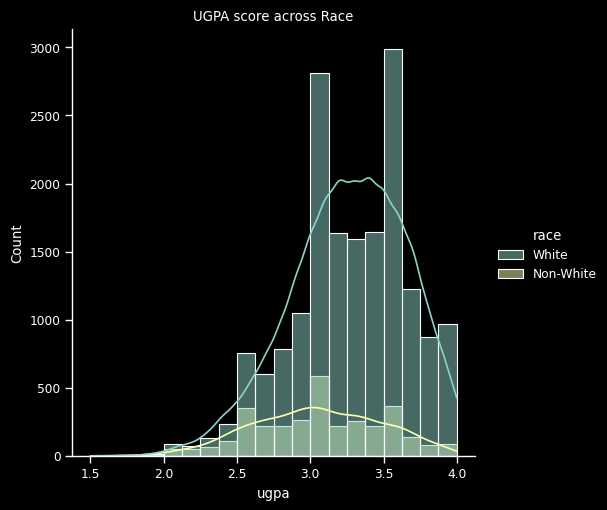

In [15]:
# plot distribution of lsat scores across races
var = 'ugpa'
sns.displot(data=data_df, x=var, hue='race', kde=True, bins=20)
plt.title(f'{var.upper()} score across Race')
plt.show()

# Pre-processing

In [16]:
## Training Test Split
train_df = data_df.sample(frac=0.8, random_state=42)
test_df = data_df.drop(train_df.index)

In [17]:
test_white_idx = test_df['race']=='White'
test_nw_idx = test_df['race']!='White'

In [18]:
# standardize numerical features
for feature in numerical_features:
    scaler = StandardScaler()
    train_df[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1,1))
    test_df[feature] = scaler.transform(test_df[feature].values.reshape(-1,1))

In [19]:
# one-hot encode categorical features
for feature in categorical_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [20]:
train_df.head()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,fulltime,male,race,pass_bar,...,tier_2.0,tier_3.0,tier_4.0,tier_5.0,tier_6.0,fam_inc_1.0,fam_inc_2.0,fam_inc_3.0,fam_inc_4.0,fam_inc_5.0
1346,0.848185,0.146772,-1.256920,1.877654,0.652848,0.223523,1.0,0.0,White,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14568,1.197875,1.545796,-0.514455,0.414814,0.845938,1.800082,1.0,1.0,Non-White,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14700,1.547565,1.545796,-1.071304,-1.535639,1.983023,1.557534,1.0,0.0,Non-White,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10881,1.547565,1.545796,0.228010,0.171008,1.940114,2.436769,1.0,0.0,White,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16459,1.547565,1.545796,0.413626,0.414814,1.618297,1.426154,1.0,1.0,White,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# one hot encode binary features
for feature in binary_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [22]:
test_white_df = test_df[test_white_idx]
test_nw_df = test_df[test_nw_idx]

# Models

## Logistic Regression

In [23]:
# create logistic regression instance
lreg = LogisticRegression(penalty='l2')

# fit model
lreg.fit(train_df.drop('pass_bar', axis=1), train_df['pass_bar'])

# get predictions on test set
lreg_y_pred = lreg.predict(test_df.drop('pass_bar', axis=1))
lreg_y_proba = lreg.predict_proba(test_df.drop('pass_bar', axis=1))

lreg_w_y_pred = lreg.predict(test_white_df.drop('pass_bar', axis=1))
lreg_nw_y_pred = lreg.predict(test_nw_df.drop('pass_bar', axis=1))

# get confusion matrix
lreg_confusion_matrix = confusion_matrix(test_df['pass_bar'], lreg_y_pred)
lreg_w_confusion_matrix = confusion_matrix(test_white_df['pass_bar'], lreg_w_y_pred)
lreg_nw_confusion_matrix = confusion_matrix(test_nw_df['pass_bar'], lreg_nw_y_pred)

## Random Forest

In [24]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# fit model
rforest.fit(train_df.drop('pass_bar', axis=1), train_df['pass_bar'])

# get predictions on test set
rforest_y_pred = rforest.predict(test_df.drop('pass_bar', axis=1))
rforest_y_proba = rforest.predict_proba(test_df.drop('pass_bar', axis=1))

rforest_w_y_pred = rforest.predict(test_white_df.drop('pass_bar', axis=1))
rforest_nw_y_pred = rforest.predict(test_nw_df.drop('pass_bar', axis=1))

# get confusion matrix
rforest_confusion_matrix = confusion_matrix(test_df['pass_bar'], rforest_y_pred)
rforest_w_confusion_matrix = confusion_matrix(test_white_df['pass_bar'], rforest_w_y_pred)
rforest_nw_confusion_matrix = confusion_matrix(test_nw_df['pass_bar'], rforest_nw_y_pred)

# Metrics

In [25]:
def compute_metrics(c_matrices):
    accuracies = {}

    for model in c_matrices.keys():
        accuracies[model] = {}
        for group in c_matrices[model].keys():
            accuracies[model][group] = compute_accuracy(c_matrices[model][group])
            print(f'{model} {group} accuracy: {accuracies[model][group]}')
    print('\n')

    # tpr 
    tprs = {}

    for model in c_matrices.keys():
        tprs[model] = {}
        for group in c_matrices[model].keys():
            tprs[model][group] = compute_true_positive_rate(c_matrices[model][group])
            print(f'{model} {group} TPR: {tprs[model][group]}')
    print('\n')
    
    # tnr
    tnrs = {}

    for model in c_matrices.keys():
        tnrs[model] = {}
        for group in c_matrices[model].keys():
            tnrs[model][group] = compute_true_negative_rate(c_matrices[model][group])
            print(f'{model} {group} TNR: {tnrs[model][group]}')
    print('\n')

    # statistical parity
    statistical_parity = {}

    for model in c_matrices.keys():
        statistical_parity[model] = compute_statistical_parity(c_matrices[model]['White'], c_matrices[model]['Non-White'])
        print(f'{model} statistical parity: {statistical_parity[model]}')
    print('\n')

    # equalized odds
    equalized_odds = {}

    for model in c_matrices.keys():
        equalized_odds[model] = compute_equalized_odds(c_matrices[model]['White'], c_matrices[model]['Non-White'])
        print(f'{model} equalized odds: {equalized_odds[model]}')
    print('\n')

In [26]:
c_matrices = {
    'Logistic Regression': {
        'All': lreg_confusion_matrix,
        'White': lreg_w_confusion_matrix,
        'Non-White': lreg_nw_confusion_matrix,
    },
    'Random Forest': {
        'All': rforest_confusion_matrix,
        'White': rforest_w_confusion_matrix,
        'Non-White': rforest_nw_confusion_matrix,
    }
}


In [27]:
compute_metrics(c_matrices)

Logistic Regression All accuracy: 0.8927884615384616
Logistic Regression White accuracy: 0.9190751445086706
Logistic Regression Non-White accuracy: 0.7628571428571429
Random Forest All accuracy: 0.8932692307692308
Random Forest White accuracy: 0.9182080924855491
Random Forest Non-White accuracy: 0.77


Logistic Regression All TPR: 0.9761452968284088
Logistic Regression White TPR: 0.9889971707010374
Logistic Regression Non-White TPR: 0.8956692913385826
Random Forest All TPR: 0.9804825155868799
Random Forest White TPR: 0.9918264696636278
Random Forest Non-White TPR: 0.9094488188976378


Logistic Regression All TNR: 0.23991507430997877
Logistic Regression White TNR: 0.12186379928315412
Logistic Regression Non-White TNR: 0.4114583333333333
Random Forest All TNR: 0.21019108280254778
Random Forest White TNR: 0.07885304659498207
Random Forest Non-White TNR: 0.4010416666666667


Logistic Regression statistical parity: 0.09332787936245479
Random Forest statistical parity: 0.08237765076598991




In [28]:
# computing abroca 
## adding prediction column to test dataframes
# copy test_df
test_df['lreg_proba'] = lreg_y_proba[:,1]
test_df['rforest_proba'] = rforest_y_proba[:,1]

# map pass_bar to 1 and 0
test_df['pass_bar'] = test_df['pass_bar'].map({1.0: 1, 0.0: 0})

## map race_White to white and non-white
test_df['race_White'] = test_df['race_White'].map({1.0: 'White', 0.0: 'Non-White'})

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


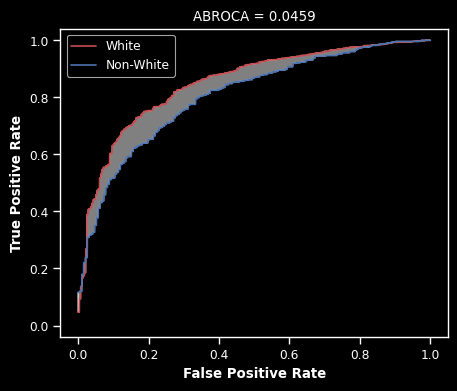

In [29]:
compute_abroca(
    test_df, 
    pred_col='lreg_proba', 
    label_col='pass_bar', 
    p_attr_col='race_White', 
    np_p_attr_val='White', 
    plot_slices=True,
    np_group_name = 'White',
    p_group_name = 'Non-White')

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


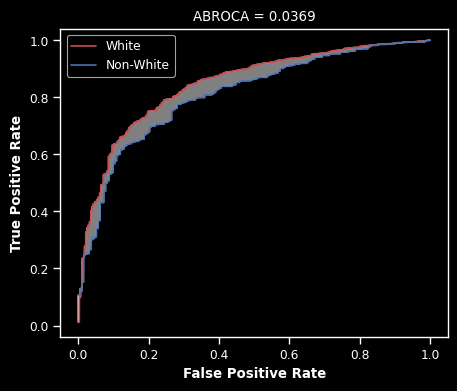

In [30]:
compute_abroca(
    test_df, 
    pred_col='rforest_proba', 
    label_col='pass_bar', 
    p_attr_col='race_White', 
    np_p_attr_val='White', 
    plot_slices=True,
    np_group_name = 'White',
    p_group_name = 'Non-White')